# Классификация тональности текста


Анализ тональности текста, или сентимент-анализ (от англ. sentiment, «настроение»), выявляет эмоционально окрашенные слова. Этот инструмент помогает компаниям оценивать, например, реакцию на запуск нового продукта в интернете. На разбор тысячи отзывов человек потратит несколько часов, а компьютер — пару минут.
Оценить тональность — значит отметить текст как позитивный или негативный. То есть мы решаем задачу классификации, где целевой признак равен «1» для положительного текста и «0» для отрицательного.

**План решения:**

1) решим задачу классификации без сложных NLP моделей которые строят эмбединги(типа BERT) с использованием TF-IDF

1.   Предобработка (очистка от лишних символов,лемматизация, удаление стоп-слов)
2.   Деление на train / test с сохранением баланса классов
3.   Построение пайплайна (генерация фичей (мешок слов (ngrams), tf-idf), модель (например, логистическая регрессия) и подбор гиперпараметров на кроссвалидации
4. Тестирование итоговой модели на тестовой выборке


 2) Построим эмбединги слов с помощью предобученного RuBERT и далее полученный признаки подадим на вход модели для классификации (можно использовать снова Логистическую регрессию или добавить последним слой полносвязной НС c сигмойдой на выходе (для получения вероятностей))

## Загрузка и ознакомление с данными

In [ ]:
#ссылка по которой лежит датасет
url = 'https://drive.google.com/file/d/18cB1yOsyzMxZZyZBfxz7ufvkBL0ZxURD/view?usp=drive_link'

file_id = url.split('/')[-2]

dwn_url = 'https://drive.google.com/uc?id=' + file_id

print(f'file_id -> copy it and insert below (with gdown) {file_id}')
print(f'download_url {dwn_url}')

file_id -> copy it and insert below (with gdown) 18cB1yOsyzMxZZyZBfxz7ufvkBL0ZxURD
download_url https://drive.google.com/uc?id=18cB1yOsyzMxZZyZBfxz7ufvkBL0ZxURD


In [ ]:
!gdown 18cB1yOsyzMxZZyZBfxz7ufvkBL0ZxURD

Downloading...
From: https://drive.google.com/uc?id=18cB1yOsyzMxZZyZBfxz7ufvkBL0ZxURD
To: /content/tweets_train.csv
100% 1.26M/1.26M [00:00<00:00, 198MB/s]


In [ ]:
#pip install catboost

In [ ]:
import pandas as pd
import numpy as np

import re
from tqdm import *

import nltk
from nltk.corpus import stopwords

from pymystem3 import Mystem

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
    recall_score,
    precision_score)

import warnings
warnings.filterwarnings("ignore")


RANDOM_STATE = 2604

In [ ]:
try:
    df = pd.read_csv('/content/tweets_train.csv')
except:
    print('Check the path')

In [ ]:
df.head(10)

,text,positive,lemm_text
0,"@first_timee хоть я и школота, но поверь, у на...",1,хоть я и школотый но поверь у мы то же самый о...
1,"Да, все-таки он немного похож на него. Но мой ...",1,да весь таки он немного похожий на он но мой м...
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,ну ты идиотка я испугаться за ты
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,кто то в угол сидеть и погибать от голод а мы ...
4,@irina_dyshkant Вот что значит страшилка :D\r\...,1,вот что значит страшилка но блин посмотреть ве...
5,ну любишь или нет? — Я не знаю кто ты бля:D ht...,1,ну любить или нет я не знать кто ты бля
6,"RT @SpoonLamer: Ох,900 :D ну это конечно же @t...",1,ох ну это конечно же чтобы у нея быть много др...
7,RT @veregijytaqo: У тебя есть ухажёр? Нет - мо...,1,у ты есть ухажёр нет мой ухо не кто не жрать
8,Поприветствуем моего нового читателя @Alexey17...,1,поприветствовать мой новое читатель
9,Теперь у меня есть частичка Сиднея :) #Sydney ...,1,теперь у я есть частичка сидней


В исходном датасете уже есть столбец с лемматизированным тектом, однако мы его удалим и оставим только исходный текст и столбец с оценкой (1- позитивный, 0 - негативный)

In [ ]:
df.drop(columns='lemm_text', inplace=True)

In [ ]:
df.head()

,text,positive
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\r\...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      5000 non-null   object
 1   positive  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [ ]:
df['positive'].mean()

0.5

Выборка сбалансирована

In [ ]:
df[df['positive'] == 1].head(10)

,text,positive
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\r\...,1
5,ну любишь или нет? — Я не знаю кто ты бля:D ht...,1
6,"RT @SpoonLamer: Ох,900 :D ну это конечно же @t...",1
7,RT @veregijytaqo: У тебя есть ухажёр? Нет - мо...,1
8,Поприветствуем моего нового читателя @Alexey17...,1
9,Теперь у меня есть частичка Сиднея :) #Sydney ...,1


Комментарии выше имеют положительный окрас

In [ ]:
df[df['positive'] == 0].head(10)

,text,positive
2500,на работе был полный пиддес :| и так каждое за...,0
2501,"Коллеги сидят рубятся в Urban terror, а я из-з...",0
2502,@elina_4post как говорят обещаного три года жд...,0
2503,"Желаю хорошего полёта и удачной посадки,я буду...",0
2504,"Обновил за каким-то лешим surf, теперь не рабо...",0
2505,"Котёнка вчера носик разбила, плакала и расстра...",0
2506,"@juliamayko @O_nika55 @and_Possum Зашли, а то ...",0
2507,а вообще я не болею - я не выздоравливаю :(,0
2508,я микрофраза :( учимся срать кирпичами в режим...,0
2509,"я хочу с тобой помириться , но сука я гордая и...",0


Комментарии выше имеют негативный окрас (негативное настроение)

In [ ]:
df.loc[2508,'text']

'я микрофраза :( учимся срать кирпичами в режиме &amp;quot;нон-стоп&amp;quot; @niwoqisipapy'

## Предобработка данных

### Очистка текста

Напишем функцию для очистки текста от лишних символов, пробелов и приведем всё к нижнем регистру

In [ ]:
def clear_text(text):
    text = re.sub(r'[^а-яА-Я]', " ", text.lower()) #lower

    return " ".join(text.split())

Применим функцию к датасету ниже (после выполнения лемматизации)





### Лемматизация текста

Для сложных моделей по типу BERT предварительная лемматизация не требуется

В данном же случае мы пока такие модели не используем, поэтому создадим доп столбец с лемматизированным текстом

In [ ]:
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


Применим лемматизацию и затем сразу же выполним очистку текста

In [ ]:
for i in tqdm(range(len(df))):
    df.loc[i, 'lemm_clear_text'] = clear_text(''.join(m.lemmatize(df.loc[i, 'text'])))

100%|██████████| 5000/5000 [00:05<00:00, 928.78it/s]


In [ ]:
df.head()

,text,positive,lemm_clear_text
0,"@first_timee хоть я и школота, но поверь, у на...",1,хоть я и школоть но поверять у мы то же самый ...
1,"Да, все-таки он немного похож на него. Но мой ...",1,да все таки он немного похожий на он но мой ма...
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,ну ты идиотка я испугаться за ты
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,кто то в угол сидеть и погибать от голод а мы ...
4,@irina_dyshkant Вот что значит страшилка :D\r\...,1,вот что значить страшилка но блин посмотреть в...


### Деление на выборки

In [ ]:
# Разделение на признаки (X) и целевую переменную (y)
X = df['lemm_clear_text']
y = df['positive']

In [ ]:
#Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE, stratify=df['positive'], shuffle=True)
print(f'train_size / test_size = {X_train.shape[0] / X_test.shape[0]}')
print(f'balance of class in df = {df["positive"].mean():.2f}')
print(f'balance of class in train = {y_train.mean():.2f}')
print(f'balance of class in test = {y_test.mean():.2f}')

train_size / test_size = 9.0
balance of class in df = 0.50
balance of class in train = 0.50
balance of class in test = 0.50


Деление на выборки выполнено успешно с сохранением стратификации по таргету

## Подготовка модели

### Построение pipeline LogRegression

In [ ]:
nltk.download('stopwords')
stop_words_list = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Построим pipeline:
- 1 шаг - векторизатор с использованием TF IDF + удаление лишних слов (стоп слов)
- классификатор (любая МЛ модель) - для начала возьмем логистическую регрессию

In [ ]:
pipe = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=list(stop_words_list))),
        ("clf", LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [ ]:
#checking the steps
pipe.steps[0]

('vect',
 TfidfVectorizer(stop_words=['нет', 'теперь', 'почти', 'после', 'того', 'про',
                             'тоже', 'моя', 'тут', 'только', 'больше', 'чтоб',
                             'были', 'вам', 'под', 'себя', 'уже', 'не', 'разве',
                             'тебя', 'том', 'иногда', 'его', 'ну', 'всего', 'в',
                             'им', 'так', 'ее', 'во', ...]))

In [ ]:
pipe.steps[1]

('clf', LogisticRegression(random_state=2604))

In [ ]:
#задаем параметры сетки
param_grid = {
    'vect__ngram_range' : ((1, 1), (1, 2), (2, 2)), # tuple (min_n, max_n)
    'clf__penalty' : ['l2', None, 'l1', 'elasticnet'], #['l2', None, 'l1', 'elasticnet']
    'clf__solver' : ['lbfgs', 'liblinear', 'saga']
}

#настраиваем GridSearchCV
grid_search_lg = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           cv=5, #небольшой датасет - возьмем 5 фолдов
                           scoring='f1', #настраиваем метрику на нашу: F1-score
                           n_jobs=-1
                          )

In [ ]:
%%time
#обучение модели Лог регрессия (сетки)
grid_search_lg.fit(X_train, y_train);

CPU times: user 1.08 s, sys: 122 ms, total: 1.2 s
Wall time: 23.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['нет',
                                                                    'теперь',
                                                                    'почти',
                                                                    'после',
                                                                    'того',
                                                                    'про',
                                                                    'тоже',
                                                                    'моя',
                                                                    'тут',
                                                                    'только',
                                                                    'больше',
                                                                    'чтоб',
                                                                    'были',
                                                                    'вам',
                                                                    'под',
                                                                    'себя',
                                                                    'уже', 'не',
                                                                    'разве',
                                                                    'тебя',
                                                                    'том',
                                                                    'иногда',
                                                                    'его', 'ну',
                                                                    'всего',
                                                                    'в', 'им',
                                                                    'так', 'ее',
                                                                    'во', ...])),
                                       ('clf',
                                        LogisticRegression(random_state=2604))]),
             n_jobs=-1,
             param_grid={'clf__penalty': ['l2', None, 'l1', 'elasticnet'],
                         'clf__solver': ['lbfgs', 'liblinear', 'saga'],
                         'vect__ngram_range': ((1, 1), (1, 2), (2, 2))},
             scoring='f1')

In [ ]:
print(f'Best_parametrs: {grid_search_lg.best_params_}')
print(f'Best F1-score: {(grid_search_lg.best_score_)}')

Best_parametrs: {'clf__penalty': 'l1', 'clf__solver': 'saga', 'vect__ngram_range': (1, 2)}
Best F1-score: 0.680025200316476


### Построение pipeline DecisionTreeClassifier

In [ ]:
pipe = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=list(stop_words_list))),
        ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [ ]:
pipe.steps[1]

('clf', DecisionTreeClassifier(random_state=2604))

In [ ]:
#задаем параметры сетки
param_grid = {
    'vect__ngram_range' : ((1, 1), (1, 2), (2, 2)), # tuple (min_n, max_n)
    'clf__max_depth' : [6, 8]
}

grid_search_dt = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1', #настраиваем метрику на нашу: F1-score
                           n_jobs=-1
                          )

#grid_rf = RandomizedSearchCV(estimator=pipe,
 #                       param_distributions=param_grid,
  #                      cv=3,
   #                     n_iter=10,
    #                    n_jobs=-1,
     #                   scoring='f1')

In [ ]:
%%time
#обучение модели RF (сетки)
grid_search_dt.fit(X_train, y_train);

CPU times: user 201 ms, sys: 11.5 ms, total: 212 ms
Wall time: 3.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['нет',
                                                                    'теперь',
                                                                    'почти',
                                                                    'после',
                                                                    'того',
                                                                    'про',
                                                                    'тоже',
                                                                    'моя',
                                                                    'тут',
                                                                    'только',
                                                                    'больше',
                                                                    'чтоб',
                                                                    'были',
                                                                    'вам',
                                                                    'под',
                                                                    'себя',
                                                                    'уже', 'не',
                                                                    'разве',
                                                                    'тебя',
                                                                    'том',
                                                                    'иногда',
                                                                    'его', 'ну',
                                                                    'всего',
                                                                    'в', 'им',
                                                                    'так', 'ее',
                                                                    'во', ...])),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=2604))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [6, 8],
                         'vect__ngram_range': ((1, 1), (1, 2), (2, 2))},
             scoring='f1')

In [ ]:
print(f'Best_parametrs: {grid_search_dt.best_params_}')
print(f'Best F1-score: {(grid_search_dt.best_score_)}')

Best_parametrs: {'clf__max_depth': 8, 'vect__ngram_range': (1, 1)}
Best F1-score: 0.6756293169024001


### Построение pipeline RandomForestClassifier

In [ ]:
pipe = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=list(stop_words_list))),
        ("clf", RandomForestClassifier(random_state=RANDOM_STATE))
    ]
)

In [ ]:
pipe.steps[1]

('clf', RandomForestClassifier(random_state=2604))

In [ ]:
#задаем параметры сетки
param_grid = {
    'vect__ngram_range' : ((1, 1), (1, 2), (2, 2)), # tuple (min_n, max_n)
    'clf__n_estimators' : [50, 100, 150, 200],
    'clf__max_depth' : [4, 6, 8, 10]
}

grid_rf = RandomizedSearchCV(estimator=pipe,
                        param_distributions=param_grid,
                        cv=5,
                        n_iter=100,
                        n_jobs=-1,
                        scoring='f1')

In [ ]:
%%time
#обучение модели RF (сетки)
grid_rf.fit(X_train, y_train);

CPU times: user 2 s, sys: 152 ms, total: 2.16 s
Wall time: 1min 25s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words=['нет',
                                                                          'теперь',
                                                                          'почти',
                                                                          'после',
                                                                          'того',
                                                                          'про',
                                                                          'тоже',
                                                                          'моя',
                                                                          'тут',
                                                                          'только',
                                                                          'больше',
                                                                          'чтоб',
                                                                          'были',
                                                                          'вам',
                                                                          'под',
                                                                          'себя',
                                                                          'уже',
                                                                          'не',
                                                                          'разве',
                                                                          'тебя',
                                                                          'том',
                                                                          'иногда',
                                                                          'его',
                                                                          'ну',
                                                                          'всего',
                                                                          'в',
                                                                          'им',
                                                                          'так',
                                                                          'ее',
                                                                          'во', ...])),
                                             ('clf',
                                              RandomForestClassifier(random_state=2604))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__max_depth': [4, 6, 8, 10],
                                        'clf__n_estimators': [50, 100, 150,
                                                              200],
                                        'vect__ngram_range': ((1, 1), (1, 2),
                                                              (2, 2))},
                   scoring='f1')

In [ ]:
print(f'Best_parametrs: {grid_rf.best_params_}')
print(f'Best F1-score: {(grid_rf.best_score_)}')

Best_parametrs: {'vect__ngram_range': (1, 1), 'clf__n_estimators': 200, 'clf__max_depth': 10}
Best F1-score: 0.6650472716593219


### Построение pipeline KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipe = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=list(stop_words_list))),
        ("clf", KNeighborsClassifier())
    ]
)

In [ ]:
pipe.steps[1]

('clf', KNeighborsClassifier())

In [ ]:
#задаем параметры сетки
param_grid = {
    'vect__ngram_range' : ((1, 1), (1, 2), (2, 2)), # tuple (min_n, max_n)
    'clf__n_neighbors' : [5, 7, 10, 15]
}

grid_search_knn = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           cv=3,
                           scoring='f1', #настраиваем метрику на нашу: F1-score
                           n_jobs=-1
                           )


In [ ]:
%%time
#обучение модели RF (сетки)
grid_search_knn.fit(X_train, y_train);

CPU times: user 273 ms, sys: 22.8 ms, total: 296 ms
Wall time: 12.8 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words=['нет',
                                                                    'теперь',
                                                                    'почти',
                                                                    'после',
                                                                    'того',
                                                                    'про',
                                                                    'тоже',
                                                                    'моя',
                                                                    'тут',
                                                                    'только',
                                                                    'больше',
                                                                    'чтоб',
                                                                    'были',
                                                                    'вам',
                                                                    'под',
                                                                    'себя',
                                                                    'уже', 'не',
                                                                    'разве',
                                                                    'тебя',
                                                                    'том',
                                                                    'иногда',
                                                                    'его', 'ну',
                                                                    'всего',
                                                                    'в', 'им',
                                                                    'так', 'ее',
                                                                    'во', ...])),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': [5, 7, 10, 15],
                         'vect__ngram_range': ((1, 1), (1, 2), (2, 2))},
             scoring='f1')

In [ ]:
print(f'Best_parametrs: {grid_search_knn.best_params_}')
print(f'Best F1-score: {(grid_search_knn.best_score_)}')

Best_parametrs: {'clf__n_neighbors': 7, 'vect__ngram_range': (1, 1)}
Best F1-score: 0.6671235512070895


### Вывод - выбор итоговой модели

Самое высокое качество имеет модель Логистической регрессии (F1 = 0.68). Параметры модели ниже:

In [ ]:
grid_search_lg.best_params_

{'clf__penalty': 'l1', 'clf__solver': 'saga', 'vect__ngram_range': (1, 2)}

## Тестирование итоговой модели

Для измерения качества финальной модели используем отложенную (тестовую выборку), не использованную в обучении

In [ ]:
print(f'Test final model: F1 score = {f1_score(y_test, grid_search_lg.best_estimator_.predict(X_test))}')

Test final model: F1 score = 0.6734006734006734


In [ ]:
best_model = grid_search_lg.best_estimator_

Построим матрицу ошибок:

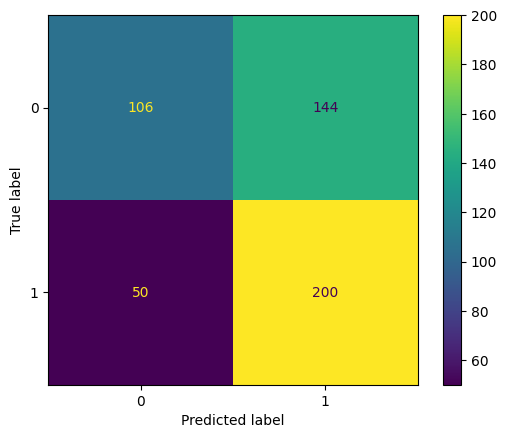

In [ ]:
cm = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = best_model.classes_)

disp.plot();

In [ ]:
recall_final_model = recall_score(y_test, best_model.predict(X_test))

print(f'Recall score for final model = {recall_final_model}')

Recall score for final model = 0.8


Метрика Recall на тестовой выборке равняется 80%, что достаточно неплохо

In [ ]:
print(f'Precision for final model = {precision_score(y_test, best_model.predict(X_test))}')

Precision for final model = 0.5813953488372093


Точность определения тональности комментария составила 58%. Изменять метрики precision, recall можно путем изменения порога присваивания меток (1 или 0). Сейчас порог стандартный: >=50% - метка 1

In [ ]:
answer = pd.DataFrame(X_test.values, columns =['text'])
answer['y_predict'] = best_model.predict(X_test)
answer['y_true'] = y_test.values
answer.head(10)

,text,y_predict,y_true
0,грусть пичаливать пересечение макпорт и бздшно...,1,0
1,я так давно ждать этот день а ты не приходить,1,0
2,как же я последний месяц обожать они слушать ж...,0,0
3,не знать что сказать хотеть чтобы ты знать что...,0,0
4,керри ты хорошо все хорошо о скучать,0,0
5,ска по литература кааак вы я сказать как весь ...,1,0
6,опять простыть все гулять катать тусовать а я ...,1,0
7,забывать вернуть в кабинет главбух вентилятор ...,1,0
8,ну да полагать случайно телефон в холодильник ...,0,1
9,мы с история выкидывать тогда ну мы и пойти в ...,1,1


Точность финальной модели классификации составила:

In [ ]:
print(f"Accuracy score of best model = {accuracy_score(y_test, best_model.predict(X_test))}")

Accuracy score of best model = 0.612


# ВТОРАЯ ЧАСТЬ работы с использованием модели BERT

In [ ]:
try:
    df = pd.read_csv('/content/tweets_train.csv')
    print('Загрузка проведена корректно')
except:
    print('Check the path')

Загрузка проведена корректно


In [ ]:
df.head(10)

,text,positive,lemm_text
0,"@first_timee хоть я и школота, но поверь, у на...",1,хоть я и школотый но поверь у мы то же самый о...
1,"Да, все-таки он немного похож на него. Но мой ...",1,да весь таки он немного похожий на он но мой м...
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,ну ты идиотка я испугаться за ты
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,кто то в угол сидеть и погибать от голод а мы ...
4,@irina_dyshkant Вот что значит страшилка :D\r\...,1,вот что значит страшилка но блин посмотреть ве...
5,ну любишь или нет? — Я не знаю кто ты бля:D ht...,1,ну любить или нет я не знать кто ты бля
6,"RT @SpoonLamer: Ох,900 :D ну это конечно же @t...",1,ох ну это конечно же чтобы у нея быть много др...
7,RT @veregijytaqo: У тебя есть ухажёр? Нет - мо...,1,у ты есть ухажёр нет мой ухо не кто не жрать
8,Поприветствуем моего нового читателя @Alexey17...,1,поприветствовать мой новое читатель
9,Теперь у меня есть частичка Сиднея :) #Sydney ...,1,теперь у я есть частичка сидней


В исходном датасете уже есть столбец с лемматизированным тектом, однако мы его удалим и оставим только исходный текст и столбец с оценкой (1- позитивный окрас, 0 - негативный окрас)

In [ ]:
df.drop(columns='lemm_text', inplace=True)

In [ ]:
df.head()

,text,positive
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\r\...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      5000 non-null   object
 1   positive  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [ ]:
df['positive'].mean()

0.5

Выборка сбалансирована по таргету

In [ ]:
df[df['positive'] == 1].head()

,text,positive
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\r\...,1


Комментарии выше имеют положительный окрас

In [ ]:
df[df['positive'] == 0].head()

,text,positive
2500,на работе был полный пиддес :| и так каждое за...,0
2501,"Коллеги сидят рубятся в Urban terror, а я из-з...",0
2502,@elina_4post как говорят обещаного три года жд...,0
2503,"Желаю хорошего полёта и удачной посадки,я буду...",0
2504,"Обновил за каким-то лешим surf, теперь не рабо...",0


Комментарии выше имеют негативный окрас (негативное настроение)

## RuBERT

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.0 MB/s eta 0:00:00


In [ ]:
#!pip deeppavlov.models.torch_bert

In [ ]:
#!pip install -q deeppavlov

In [ ]:
#!python -m deeppavlov install rusentiment_bert

In [ ]:
#from deeppavlov import build_model

#model = build_model('rusentiment_bert', download = True)

Будем использовать предобученную модель BERT для русскоязычных текстов

In [ ]:
#model_name = 'cointegrated/rubert-tiny2'
model_name = 'DeepPavlov/rubert-base-cased'

In [ ]:
import torch
import transformers

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

In [ ]:
#проверка device (доступна ли видеокарта)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU')

else:
    device = torch.device('cpu')
    print('CPU')

GPU


In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)

In [ ]:
#проверка работы токенизатора
tokenizer.encode('очень удобно использовать готовый токенизатор')

[101, 7805, 60791, 12610, 72948, 111601, 17510, 5855, 102]

In [ ]:
df.head()

,text,positive
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\r\...,1


In [ ]:
#выполним токенизацию текста
tokenized = df['text'].apply(
  lambda x: tokenizer.encode(x, add_special_tokens=True))

In [ ]:
#найдем макс длину токенизированного текста
max_len = len(max(tokenized, key=lambda p: len(p)))
max_len

132

In [ ]:
# применим padding к векторам текстов, чтобы сделать вектора одинаковой длины
padded = np.array([s + [0] * (max_len - len(s)) for s in tokenized.values])

In [ ]:
#проверим первый текст
df.loc[0, 'text']

'@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)'

In [ ]:
tokenizer.encode('хоть я и школота')

[101, 28809, 877, 851, 5364, 5866, 102]

In [ ]:
tokenizer.encode(':D')

[101, 156, 176, 102]

In [ ]:
tokenizer.encode('@first_time')

[101, 168, 10934, 230, 11147, 102]

In [ ]:
tokenizer.encode("first")

[101, 10934, 102]

In [ ]:
#проверим первый текст
padded[0]

array([  101,   168, 10934,   230, 11147,   241, 28809,   877,   851,
        5364,  5866,   128,  3435, 26063,   896,   128,   875,  3660,
        3815,  3629, 19540,   156,   176, 16270, 99860, 54412, 14806,
       10298,   122,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

Видим, что текст токенизирован корректно (выше выполнена проверка)

In [ ]:
# создадим маску для важных токенов
attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
#проверим маску для первого текста
attention_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
#загрузим обученную модель и закинем её на девайс (GPU)
model = transformers.BertModel.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
padded.shape

(5000, 132)

С помощью модели RuBERT создадим эмбеддинги наших текстов (комментариев) и потом обучим на них модель для бинарной классификации тональности

In [ ]:
BATCH_SIZE = 100

embeddings = []

for i in tqdm(range(padded.shape[0] // BATCH_SIZE)): #padded.shape[0] // BATCH_SIZE

    batch = torch.LongTensor(padded[BATCH_SIZE*i:BATCH_SIZE*(i+1)]) #берем инт тензор, так как токенизатор использовал инт
    batch = batch.to(device) #закидываем батч на девайс

    #аналогичные опреации для маски
    attention_mask_batch = torch.LongTensor(attention_mask[BATCH_SIZE*i:BATCH_SIZE*(i+1)])
    attention_mask_batch = attention_mask_batch.to(device)

    #добучать модель и высчитывать градиенты не требуется
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask = attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) #возвращаем на процессор и записываем в массив

100%|██████████| 50/50 [00:35<00:00,  1.43it/s]


In [ ]:
#соберем все эмбеддинги в матрицу признаков Х
X = np.concatenate(embeddings)

После того, как мы получили эмбединги всех текстов - можно обучить либо полносвязную нейросеть, либо модель из классического МЛ (например, логистическую регрессию)

### Подаем эмбеддинги на вход в Логистическую регрессию

In [ ]:
X = pd.DataFrame(X)
y = df['positive']

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.008579,-0.237166,-0.047278,-0.151884,-0.195215,0.052152,-0.163630,0.116843,0.082063,0.040464,...,0.066601,-0.022672,-0.421132,-0.425003,0.204644,0.000538,0.126154,0.427044,0.345448,0.147507
1,0.041382,-0.215725,-0.283716,-0.043607,0.119642,0.190368,-0.115414,-0.097796,0.169153,0.116899,...,0.207714,-0.014578,-0.675055,-0.151274,-0.072131,0.051813,0.100838,0.358062,0.603086,-0.190423
2,-0.295971,-0.177017,-0.006032,-0.342847,0.068041,0.290452,0.129810,0.470752,-0.236808,0.178364,...,-0.113149,0.165662,-0.378144,-0.030077,0.359536,-0.191526,0.541122,0.334288,0.219236,-0.209704
3,-0.128092,0.019002,-0.258775,-0.021607,0.273209,0.242218,-0.087618,0.155433,-0.106242,0.227759,...,-0.109962,0.049726,-0.241671,-0.242283,0.131821,-0.105712,0.257477,0.004974,0.175270,-0.001815
4,-0.064758,-0.217270,-0.268010,0.054080,0.034953,0.389775,0.458612,0.055656,0.027169,-0.062462,...,0.271775,0.078866,-0.710517,-0.596084,0.180630,-0.205955,0.150080,0.393814,0.476101,-0.178435


In [ ]:
#Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=df['positive'], shuffle=True)
print(f'train_size / test_size = {X_train.shape[0] / X_test.shape[0]}')
print(f'balance of class in df = {df["positive"].mean():.2f}')
print(f'balance of class in train = {y_train.mean():.2f}')
print(f'balance of class in test = {y_test.mean():.2f}')

train_size / test_size = 4.0
balance of class in df = 0.50
balance of class in train = 0.50
balance of class in test = 0.50


In [ ]:
ml_model = LogisticRegression(random_state=RANDOM_STATE)
ml_model.fit(X_train, y_train)

print(f"F1 score test = {f1_score(y_test, ml_model.predict(X_test))}")
print(f"accuracy score test = {accuracy_score(y_test, ml_model.predict(X_test))}")

F1 score test = 0.9801587301587301
accuracy score test = 0.98


Для бинарной классификации использовали Логистическую регрессию с дефолтыми параметрами. Получили точность классификации почти 98%

Ниже попробуем подобрать параметры с помощью GridSearchCV

In [ ]:
model_trained = LogisticRegression(random_state=RANDOM_STATE)

In [ ]:
#задаем параметры сетки
param_grid = {
    'penalty' : ['l2', None, 'l1', 'elasticnet'], #['l2', None, 'l1', 'elasticnet']
    'solver' : ['lbfgs', 'liblinear', 'saga']
}

#настраиваем GridSearchCV
grid_search_lg = GridSearchCV(estimator=model_trained,
                           param_grid=param_grid,
                           cv=5, #небольшой датасет - возьмем 5 фолдов
                           scoring='accuracy', #настраиваем метрику на нашу: accuracy (выборка сбалансирована)
                           n_jobs= -1
                          )

In [ ]:
%%time
#обучение модели Лог регрессия (сетки)
grid_search_lg.fit(X_train, y_train);

CPU times: user 5.99 s, sys: 176 ms, total: 6.16 s
Wall time: 1min 26s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=2604), n_jobs=-1,
             param_grid={'penalty': ['l2', None, 'l1', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

In [ ]:
print(f'Best_parametrs: {grid_search_lg.best_params_}')

print(f'Best accuracy: {(grid_search_lg.best_score_)}')

#print(f'Best F1-score: {(grid_search_lg.best_score_)}')

Best_parametrs: {'penalty': 'l2', 'solver': 'saga'}
Best accuracy: 0.976


Точность классификации по эмбеддингам отложенной (тестовой) выборки с помощью логистической регрессии составила 97.6%

### Подаем эмбеддинги на вход в полносвязную нейросеть

Для начала необходимо написать FCNN

In [ ]:
# напишем собственный класс нейронной сети
# для простоты возьмем два полносвязных слоя (между ними ф.а. ReLu и на выходе сигмоида - она вернет вероятность)
# принадлежноти к классу 1 или 0

class Sentiment_bin_clf(nn.Module):

    def __init__(self, n_inputs):
        super(Sentiment_bin_clf, self).__init__()

        #First fc layer
        self.fc1 = nn.Linear(n_inputs, 20)

        #Secong fc layer
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):

        #pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)

        #pass data through fc12
        x = self.fc2(x)

        output = F.sigmoid(x) #в качестве лосс функции будем использовать Binary Cross Entropy (на вход нужны вероятности)

        return output

In [ ]:
my_net = Sentiment_bin_clf(768) #длина вектора embeding после RuBERT 768
print(my_net)

Sentiment_bin_clf(
  (fc1): Linear(in_features=768, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)


In [ ]:
#соберем все эмбеддинги в матрицу признаков Х
X = np.concatenate(embeddings) #np array

In [ ]:
y = df['positive'].values #np array

In [ ]:
#Разделение данных на обучающую и тестовую выборки
X_train, X_test_valid, y_train, y_test_valid = \
train_test_split(X, y, test_size=0.6, random_state=RANDOM_STATE, stratify=df['positive'], shuffle=True)

#делим на валидационную и тестовую (отложенную выборку для финального тестирования)
X_valid, X_test, y_valid, y_test = \
train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=RANDOM_STATE, shuffle=True)

print(f'train_size / valid_size = {X_train.shape[0] / X_valid.shape[0]}')
print(f'train_size / test_size = {X_train.shape[0] / X_test.shape[0]}')
print(f'balance of class in df = {df["positive"].mean():.2f}')
print(f'balance of class in train = {y_train.mean():.2f}')
print(f'balance of class in valid = {y_valid.mean():.2f}')
print(f'balance of class in test = {y_test.mean():.2f}')

X_train = torch.from_numpy(X_train) #numpy array to tensor
X_valid = torch.from_numpy(X_valid) #numpy array to tensor
X_test = torch.from_numpy(X_test) #numpy array to tensor

y_train = torch.from_numpy(y_train) #numpy array to tensor
y_valid = torch.from_numpy(y_valid) #numpy array to tensor
y_test = torch.from_numpy(y_test) #numpy array to tensor

y_train = y_train.unsqueeze(1) #reshape
y_valid = y_valid.unsqueeze(1)
y_test = y_test.unsqueeze(1)

y_train = y_train.float() #устранение ошибки с float
y_valid = y_valid.float()
y_test = y_test.float()

train_size / valid_size = 1.3333333333333333
train_size / test_size = 1.3333333333333333
balance of class in df = 0.50
balance of class in train = 0.50
balance of class in valid = 0.49
balance of class in test = 0.51


In [ ]:
#создадим загрузчики данных для обучающей и тестовой выборки

batch_size = 100

#train
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# validation dataset
valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#test
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(train_loader.batch_size)

100


In [ ]:
Batch = next(iter(train_loader)) #features and target

#Batch[1][0] - target for 1st text
#Batch[0][0] - features for 1st text (embeddings for 1st text)
print(Batch[1][0])

tensor([0.])


In [ ]:
model = Sentiment_bin_clf(768)

print(model)

Sentiment_bin_clf(
  (fc1): Linear(in_features=768, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)


In [ ]:
#optimizer setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # for SGD momentum=0.9)

#loss function
loss_fn = torch.nn.BCELoss() #Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities

In [ ]:
#напишем обучающую функцию для одной эпохи

def train_one_epoch(epoch_index):
    running_loss = 0
    last_loss = 0

    for i, data in enumerate(train_loader):

        inputs, labels = data

        optimizer.zero_grad() #обнуляем градиенты

        outputs = model(inputs) #make prediction for this batch

        loss = loss_fn(outputs, labels)

        loss.backward()

        optimizer.step() #adjust learning weights

        running_loss += loss.item()

        if i % 10 == 0:
            last_loss = running_loss / 10 #loss per batch
            print(f"batch {i} loss = {last_loss}")
            running_loss = 0

    return last_loss



In [ ]:
EPOCHS = 200

epoch_number = 0 #to train at 1 epoch function train_one_epoch

best_vloss = 1000000

vloss_plot = []

for epoch in range(EPOCHS):

    print(f"EPOCHS {epoch+1}")

    model.train(True)

    avg_loss = train_one_epoch(epoch_number)

    running_v_loss = 0 #loss на валидации

    model.eval() # переход в eval mode

    with torch.no_grad():
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_v_loss += vloss

    avg_v_loss = running_v_loss / (i+1)

    print(f"Loss train = {avg_loss:.4f} valid loss = {avg_v_loss:.4f}")

    if avg_v_loss < best_vloss:
        best_vloss = avg_v_loss

    vloss_plot.append((best_vloss.numpy(), epoch))

    epoch_number += 1

EPOCHS 1
batch 0 loss = 0.06906591057777405
batch 10 loss = 0.6838737785816192
Loss train = 0.6839 valid loss = 0.6600
EPOCHS 2
batch 0 loss = 0.06569715738296508
batch 10 loss = 0.6450692296028138
Loss train = 0.6451 valid loss = 0.6165
EPOCHS 3
batch 0 loss = 0.061178797483444215
batch 10 loss = 0.596744978427887
Loss train = 0.5967 valid loss = 0.5688
EPOCHS 4
batch 0 loss = 0.05470917820930481
batch 10 loss = 0.549958598613739
Loss train = 0.5500 valid loss = 0.5269
EPOCHS 5
batch 0 loss = 0.051854890584945676
batch 10 loss = 0.5082187861204147
Loss train = 0.5082 valid loss = 0.4906
EPOCHS 6
batch 0 loss = 0.047016608715057376
batch 10 loss = 0.46303613781929015
Loss train = 0.4630 valid loss = 0.4528
EPOCHS 7
batch 0 loss = 0.04455675482749939
batch 10 loss = 0.4249424397945404
Loss train = 0.4249 valid loss = 0.4209
EPOCHS 8
batch 0 loss = 0.037784275412559507
batch 10 loss = 0.389102104306221
Loss train = 0.3891 valid loss = 0.3935
EPOCHS 9
batch 0 loss = 0.034108716249465945
b

In [ ]:
results = pd.DataFrame(vloss_plot, columns=["valid_loss", "epoch_number"])
results.tail()

,valid_loss,epoch_number
195,0.075278535,195
196,0.07486467,196
197,0.07486467,197
198,0.07486467,198
199,0.07486467,199


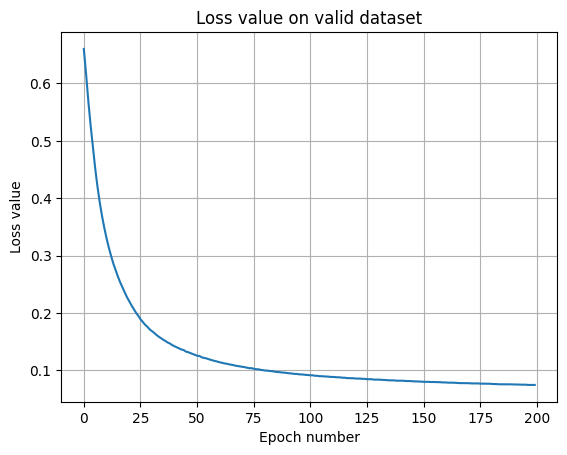

In [ ]:
plt.grid(True)

plt.plot(results['epoch_number'], results['valid_loss'])

plt.title('Loss value on valid dataset')
plt.xlabel('Epoch number')
plt.ylabel('Loss value')
plt.show()


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.9 MB/s eta 0:00:00


Проверка качества нашей обученной полносвязной НС на отложенной (тестовой) выборке

In [ ]:
from torch import tensor
from torchmetrics.classification import BinaryAccuracy

model.eval()
#true_labels = []
#predicted_probs = []
target = y_test

with torch.no_grad():
    outputs = model(X_test)
    metric = BinaryAccuracy()
    print(metric(outputs, target))

tensor(0.9727)


Точность на отложенной (тестовой) выборке составила 97%, что является хорошим результатом. Такое же качество (accuracy) имела логистическая регрессия. Поэтому использование НС в данной задаче для классификации тональности комментариев по эмбеддингам (полученным через RuBERT) не повышает точность

# Вывод

В данном проекте решалась задача классификации тональности комментариев (имеют положительный или негативный окрас)

В ходе решения была использована модель RuBERT для построения эмбеддингов текстов. Затем эти эмбеддинги стали признаками для моделей классификации:
- логистической регрессии (точность на тесте составила 97.6%)
- полносвязная нейронная сеть (точность на тесте составила 97.2%)

Таким образом - построение эмбеддингов с помощью модели RuBERT существенно повышает точность классификации, по сравнению с использованием подхода TF-IDF (там точность составила всего 61% на отложенной тестовой выборке)